In [108]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
import statsmodels.graphics.tsaplots as tsaplots
from stargazer.stargazer import Stargazer
import glob
import datetime as dt

sns.set_context("paper", font_scale=1.6)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

# Import Data

In [2]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    ticker_dfs.append(ticker_df)

rawdata_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 2.56 s, sys: 3.16 s, total: 5.72 s
Wall time: 4.35 s


In [3]:
%%time
data_files = glob.glob("../data/prices/tickers_clean/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    ticker_dfs.append(ticker_df)

data_prices_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 6.72 s, sys: 17.5 s, total: 24.2 s
Wall time: 25.8 s


In [4]:
%%time
data_mcap_df = pd.read_csv('../data/wrds/market_cap.csv')

## Market cap data cleaning
data_mcap_df['year'] = data_mcap_df['fyear']
data_mcap_df['ticker'] = data_mcap_df['tic']
data_mcap_df = data_mcap_df[['year', 'ticker', 'mkvalt']].dropna()
data_mcap_df['year'] = data_mcap_df['year'].astype(int)
data_mcap_df.sample(5)

CPU times: user 62.5 ms, sys: 62.5 ms, total: 125 ms
Wall time: 206 ms


,year,ticker,mkvalt
1846,2019,NKE,153587.6400
5785,2013,PM,138449.7443
4462,2019,ALXN,23933.5950
3735,2018,DHI,15870.7312
3230,2016,DVN,23885.4100


In [5]:
%%time
data_ff_df = pd.read_csv('../data/wrds/ff_betas.csv')

# Clean up cols
data_ff_df['ticker'] = data_ff_df['TICKER']
data_ff_df['date'] = pd.to_datetime(data_ff_df['DATE'].astype(str)).dt.date

data_ff_df.head()

CPU times: user 4.03 s, sys: 859 ms, total: 4.89 s
Wall time: 4.91 s


,PERMNO,DATE,n,RET,alpha,b_mkt,b_smb,b_hml,ivol,tvol,R2,exret,TICKER,ticker,date
0,10104,20100930,252,-1.1760%,0.0003,1.2053,-0.1430,-0.7747,1.1117%,1.5856%,50.8410%,-0.6639%,ORCL,ORCL,2010-09-30
1,10104,20100527,252,3.0603%,-0.0000,1.2647,-0.0577,-0.7989,1.0240%,1.5128%,54.1763%,0.0239%,ORCL,ORCL,2010-05-27
2,10104,20120821,252,-0.9051%,-0.0002,1.2643,-0.1112,-0.6460,1.2734%,1.9753%,58.4382%,-0.2398%,ORCL,ORCL,2012-08-21
3,10104,20120224,252,1.5272%,-0.0010,1.2967,0.0372,-0.8066,1.2564%,2.2570%,69.0114%,0.8310%,ORCL,ORCL,2012-02-24
4,10104,20130424,252,0.1540%,-0.0002,1.2057,-0.0016,-0.1539,1.0632%,1.4567%,46.7332%,0.2801%,ORCL,ORCL,2013-04-24


# Drop 2020

In [6]:
data_rv_df = rawdata_rv_df.copy()
data_rv_df['year'] = data_rv_df['date'].dt.year
# data_rv_df = data_rv_df.query('year < 2020')

# Aggregate data

In [103]:
data_mcap_df.query('year == 2019').sort_values(by = 'mkvalt', ascending = False).head(10)

,year,ticker,mkvalt
2858,2019,MSFT,1.023856e+06
209,2019,AAPL,9.951516e+05
5397,2019,GOOGL,9.211383e+05
4553,2019,AMZN,9.202243e+05
5609,2019,FB,5.853730e+05
505,2019,JPM,4.299125e+05
506,2019,JPM,4.299125e+05
1427,2019,JNJ,3.840038e+05
5780,2019,V,3.725450e+05
5781,2019,V,3.725450e+05


In [7]:
%%time
daily_prices_df = data_prices_df.groupby(['ticker', 'date'])['price'].last().reset_index()
daily_prices_df['log_price'] = np.log(daily_prices_df['price'])

CPU times: user 3.61 s, sys: 3.44 s, total: 7.05 s
Wall time: 7.06 s


# Rolling Beta Analysis

## Rolling Beta Estimates

In [8]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [9]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

In [10]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  # ["AAPL", "AMZN", "FB", "BAC", "XOM", "T", "INTC", "HD", "KO", "CSCO"]
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 922 ms, sys: 6.7 s, total: 7.62 s
Wall time: 46.1 s


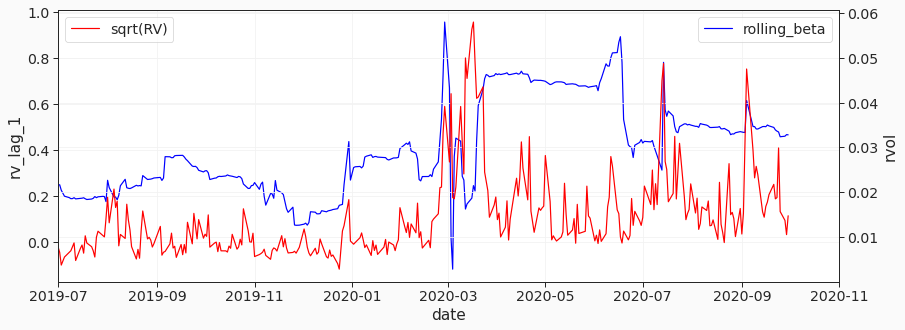

In [11]:
fig, ax = plt.subplots(figsize = (14,5))
sns.lineplot(x = 'date', y = 'rv_lag_1', label = 'rolling_beta', color = 'blue', data = rolling_beta_df.query('ticker == "AMZN"').query('date > "2019/01/01"'), ax = ax)
ax_alt = ax.twinx()
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])
sns.lineplot(x = 'date', y = 'rvol', label = 'sqrt(RV)',  color = 'red', data = data_rv_df.query('ticker == "AMZN"').query('date > "2019/01/01"'), ax = ax_alt)
plt.xlim(pd.to_datetime('2019-07-01'), pd.to_datetime('2020-11-01'))
plt.legend(loc = 'upper left')

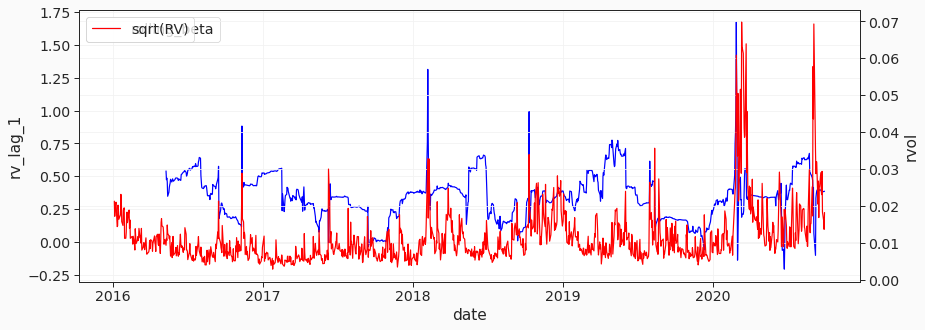

In [12]:
fig, ax = plt.subplots(figsize = (14,5))
sns.lineplot(x = 'date', y = 'rv_lag_1', label = 'rolling_beta', color = 'blue', data = rolling_beta_df.query('ticker == "AAPL"'), ax = ax)
ax_alt = ax.twinx()
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])
sns.lineplot(x = 'date', y = 'rvol', label = 'sqrt(RV)',  color = 'red', data = data_rv_df.query('ticker == "AAPL"'), ax = ax_alt)
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-12-31'))
plt.legend(loc = 'upper left')

In [13]:
rolling_beta_df['persistence'] = rolling_beta_df['rv_lag_1'] + rolling_beta_df['rv_lag_m5'] + rolling_beta_df['rv_lag_m22']

### Beta_1

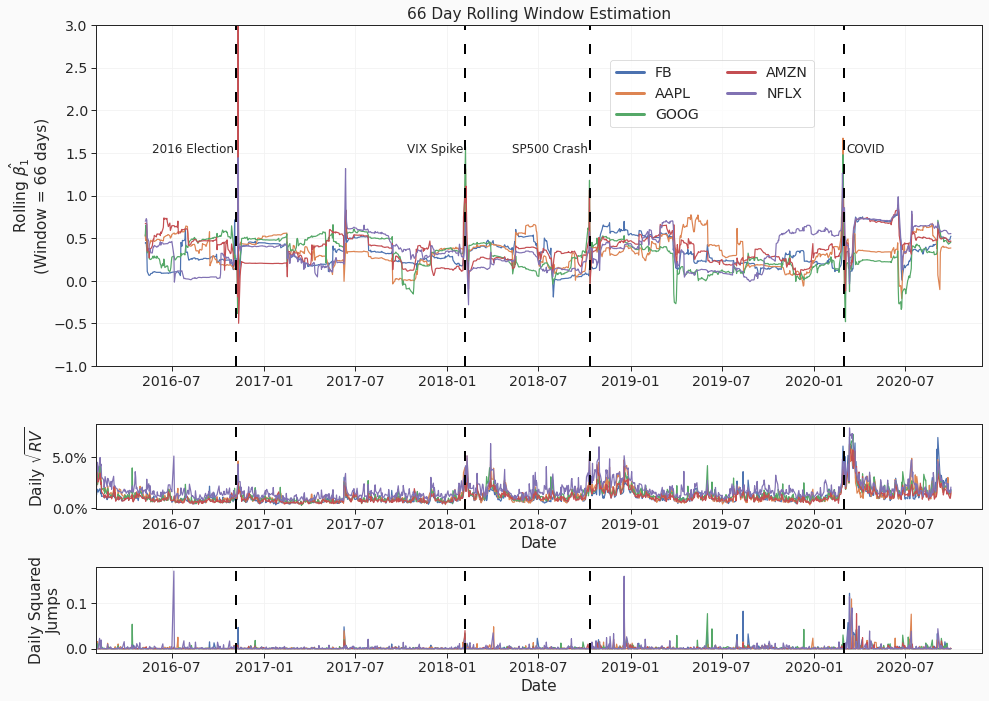

In [162]:
fig, axs = plt.subplots(
    figsize=(14, 10), nrows=3, gridspec_kw={"height_ratios": [4, 1, 1]}
)
ticker_subset = ["FB", "AAPL", "AMZN", "NFLX", "GOOG"]

ax = axs[0]
sns.lineplot(
    x="date",
    y="rv_lag_1",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=rolling_beta_df.query("ticker in @ticker_subset"),
    ax=ax,
)

ax.set_xlabel("")
ax.set_ylabel("Rolling $\\hat{\\beta_1}$\n(Window = " + f"{window} days)")
ax.set_title(f"{window} Day Rolling Window Estimation")
ax.set_ylim(-1,3)

ax.legend(ncol=2, loc = (0.58, 0.7))
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

# # Prices
# ax = axs[1]
# ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, ls="dashed", color="black")
# sns.lineplot(
#     x="date",
#     y="log_price",
#     hue="ticker",
#     palette="deep",
#     lw=1.2,
#     data=daily_prices_df.query("ticker in @ticker_subset")
#     .groupby(["date", "ticker"])["log_price"]
#     .last()
#     .reset_index(),
#     ax=ax,
# )
# ax.set_xlabel("")
# ax.set_ylabel("Price Index\n(100)")
# ax.get_legend().remove()

# Realized Volatility
ax = axs[1]
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])
sns.lineplot(
    x="date",
    y="rvol",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")
ax.set_ylabel("Daily $\\sqrt{RV}$")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Sum of Squared Jumps
ax = axs[2]
sns.lineplot(
    x="date",
    y="sum_jump_p2_1",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query(f"ticker in @ticker_subset"),
    ax = ax
)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Squared\nJumps')
ax.get_legend().remove()


for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime('2016/02/01'), pd.to_datetime('2020/12/01'))
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    
axs[0].text(pd.to_datetime("2016-11-01"), 1.5, '2016 Election', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-02-01"), 1.5, 'VIX Spike', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-10-08"), 1.5, 'SP500 Crash', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2020-03-05"), 1.5, 'COVID', fontsize = 12, ha = 'left')

plt.tight_layout()
plt.savefig(f"../exhibits/rolling_beta1.pdf")

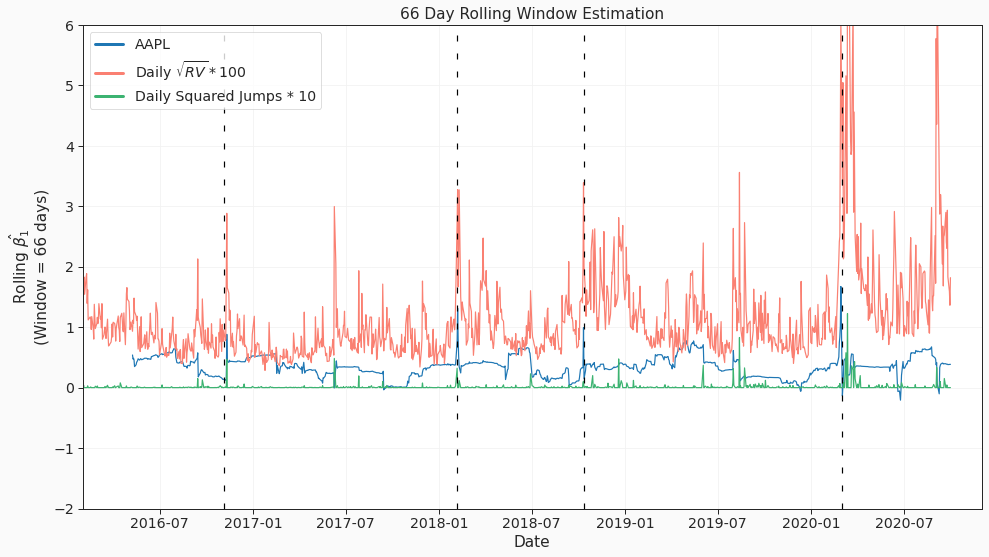

In [78]:
fig, axs = plt.subplots(
    figsize=(14, 8), nrows=1
)
ticker_subset = ["AAPL"]

ax = axs
sns.lineplot(
    x="date",
    y="rv_lag_1",
    palette="deep",
    label=ticker_subset[0],
    lw=1.2,
    data=rolling_beta_df.query("ticker in @ticker_subset"),
    ax=ax,
)

ax.set_xlabel("")
ax.set_ylabel("Rolling $\\hat{\\beta_1}$\n(Window = " + f"{window} days)")
ax.set_title(f"{window} Day Rolling Window Estimation")
ax.set_ylim(-2,6)

# Realized Volatility
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])*100
sns.lineplot(
    x="date",
    y="rvol",
    label = "Daily $\\sqrt{RV} * 100$",
    color = 'salmon',
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")

# Sum of Squared Jumps
data_rv_df['jump_measure_1'] = data_rv_df['sum_jump_p2_1']*10
sns.lineplot(
    x="date",
    y="jump_measure_1",
    color = 'mediumseagreen',
    label = 'Daily Squared Jumps * 10',
    lw=1.2,
    data=data_rv_df.query(f"ticker in @ticker_subset"),
    ax = ax
)
ax.set_xlabel('Date')


ax.legend(loc = 'best')
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

ax.set_xlim(pd.to_datetime('2016/02/01'), pd.to_datetime('2020/12/01'))
ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")

plt.tight_layout()
# plt.savefig(f"../exhibits/beta_d_rolling_{window}.pdf")

### Persistence

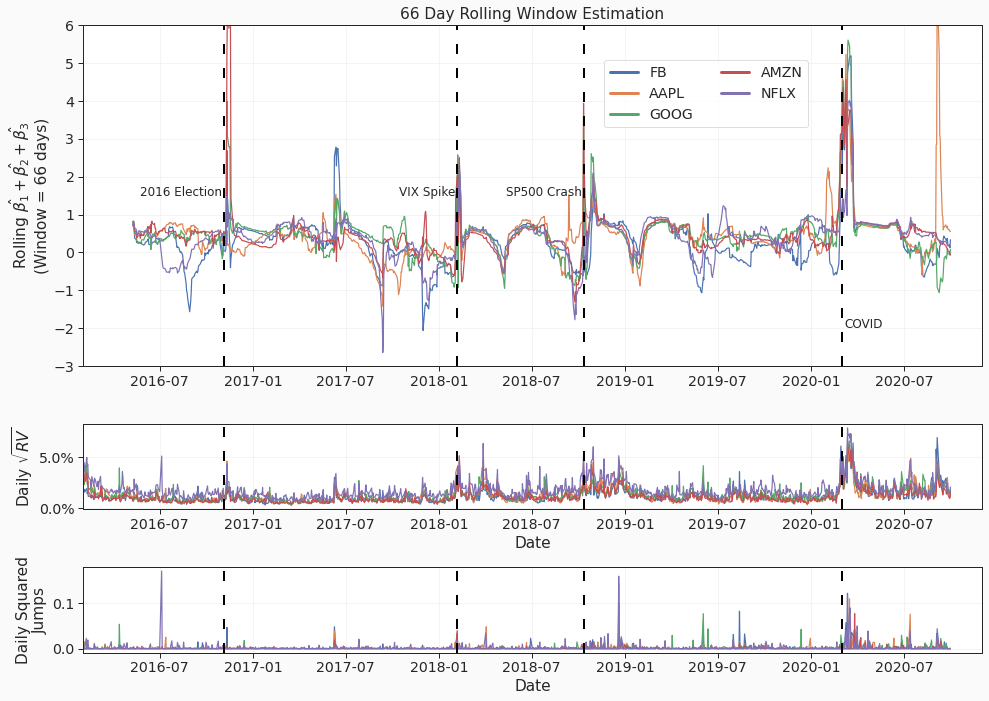

In [164]:
fig, axs = plt.subplots(
    figsize=(14, 10), nrows=3, gridspec_kw={"height_ratios": [4, 1, 1]}
)
ticker_subset = ["FB", "AAPL", "AMZN", "NFLX", "GOOG"]

ax = axs[0]
sns.lineplot(
    x="date",
    y="persistence",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=rolling_beta_df.query("ticker in @ticker_subset"),
    ax=ax,
)

ax.set_xlabel("")
ax.set_ylabel(
    "Rolling $\\hat{\\beta_1} + \\hat{\\beta_2} + \\hat{\\beta_3}$\n(Window = "
    + f"{window} days)"
)
ax.set_title(f"{window} Day Rolling Window Estimation")
ax.set_ylim(-3, 6)

ax.legend(ncol=2, loc=(0.58, 0.7))
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

# Realized Volatility
ax = axs[1]
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])
sns.lineplot(
    x="date",
    y="rvol",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")
ax.set_ylabel("Daily $\\sqrt{RV}$")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Sum of Squared Jumps
ax = axs[2]
sns.lineplot(
    x="date",
    y="sum_jump_p2_1",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query(f"ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Squared\nJumps")
ax.get_legend().remove()


for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime("2016/02/01"), pd.to_datetime("2020/12/01"))
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw=2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw=2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw=2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw=2, ls=(0, (5, 7)), color="black")
    
axs[0].text(pd.to_datetime("2016-11-01"), 1.5, '2016 Election', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-02-01"), 1.5, 'VIX Spike', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-10-08"), 1.5, 'SP500 Crash', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2020-03-05"), -2, 'COVID', fontsize = 12, ha = 'left')

plt.tight_layout()
plt.savefig(f"../exhibits/rolling_persistence.pdf")

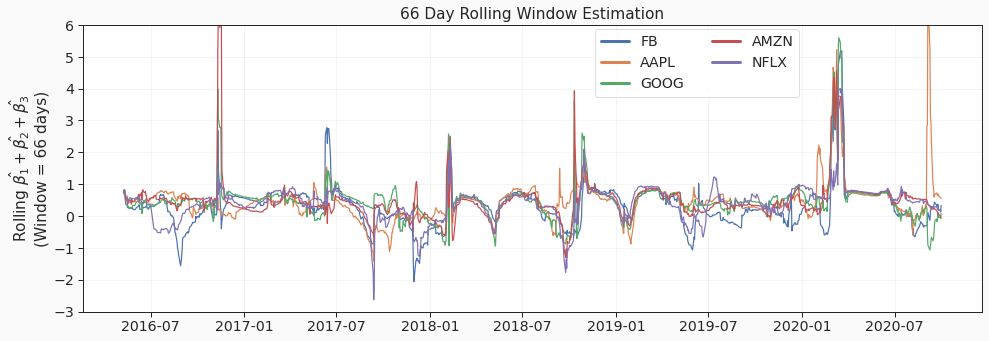

In [150]:
fig, ax = plt.subplots(
    figsize=(14, 5)
)
ticker_subset = ["FB", 'AAPL', 'AMZN', 'NFLX', 'GOOG']

# ax = axs[0]
sns.lineplot(
    x="date",
    y="persistence",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=rolling_beta_df.query("ticker in @ticker_subset"),
    ax=ax,
)

ax.set_xlabel("")
ax.set_ylabel("Rolling $\\hat{\\beta_1} + \\hat{\\beta_2} + \\hat{\\beta_3}$\n(Window = " + f"{window} days)")
ax.set_title(f"{window} Day Rolling Window Estimation")
ax.set_ylim(-3,6)

ax.legend(ncol=2, loc = (0.57, 0.75))
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)



for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime('2016/02/01'), pd.to_datetime('2020/12/01'))
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 2, ls=(0, (5, 7)), color="black")

plt.tight_layout()
plt.savefig(f"../exhibits/rolling_persistence_zoom.pdf")

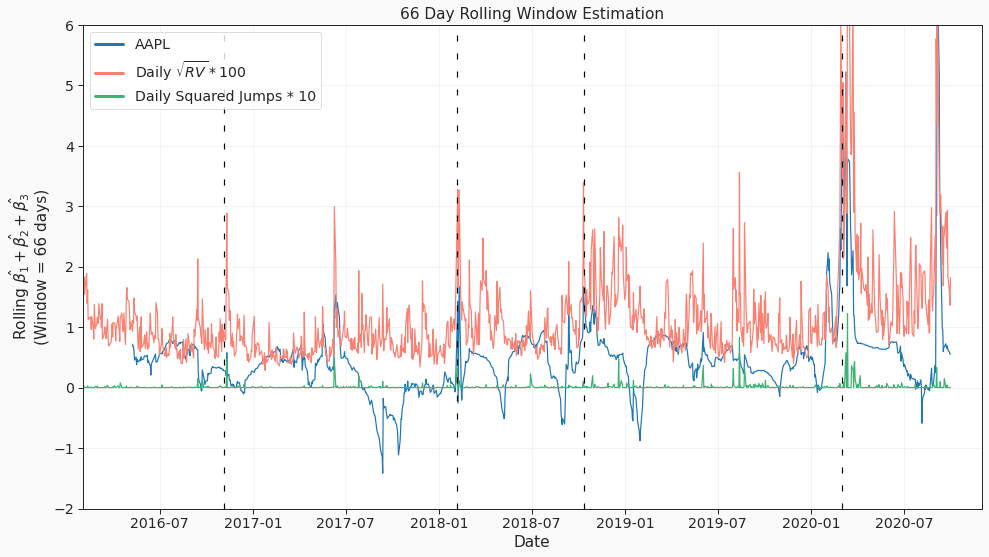

In [80]:
fig, axs = plt.subplots(
    figsize=(14, 8), nrows=1
)
ticker_subset = ["AAPL"]

ax = axs
sns.lineplot(
    x="date",
    y="persistence",
    palette="deep",
    label=ticker_subset[0],
    lw=1.2,
    data=rolling_beta_df.query("ticker in @ticker_subset"),
    ax=ax,
)

ax.set_xlabel("")
ax.set_ylabel("Rolling $\\hat{\\beta_1} + \\hat{\\beta_2} + \\hat{\\beta_3}$\n(Window = " + f"{window} days)")
ax.set_title(f"{window} Day Rolling Window Estimation")
ax.set_ylim(-2,6)

# Realized Volatility
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])*100
sns.lineplot(
    x="date",
    y="rvol",
    label = "Daily $\\sqrt{RV} * 100$",
    color = 'salmon',
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")

# Sum of Squared Jumps
data_rv_df['jump_measure_1'] = data_rv_df['sum_jump_p2_1']*10
sns.lineplot(
    x="date",
    y="jump_measure_1",
    color = 'mediumseagreen',
    label = 'Daily Squared Jumps * 10',
    lw=1.2,
    data=data_rv_df.query(f"ticker in @ticker_subset"),
    ax = ax
)
ax.set_xlabel('Date')


ax.legend(loc = 'best')
leg = ax.get_legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(3)

ax.set_xlim(pd.to_datetime('2016/02/01'), pd.to_datetime('2020/12/01'))
ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, ls=(0, (5, 10)), color="black")
ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, ls=(0, (5, 10)), color="black")
ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, ls=(0, (5, 10)), color="black")
ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, ls=(0, (5, 10)), color="black")

plt.tight_layout()
# plt.savefig(f"../exhibits/beta_d_rolling_{window}.pdf")

## ?

# Jump HAR Coefficients

In [18]:
data_rv_df = data_rv_df.sort_values(by = ['ticker', 'date'])

# Signed Jump variants
data_rv_df['sgn_jump_var_lag_1'] = data_rv_df.groupby('ticker')['sgn_jump_var'].shift(1)
data_rv_df['sgn_jump_var_pos_lag_1'] = data_rv_df['sgn_jump_var_lag_1']*(data_rv_df['sgn_jump_var_lag_1'] > 0)
data_rv_df['sgn_jump_var_neg_lag_1'] = data_rv_df['sgn_jump_var_lag_1']*(data_rv_df['sgn_jump_var_lag_1'] < 0)

data_rv_df['sgn_jump_var_m5_lag_1'] = data_rv_df.groupby('ticker')['sgn_jump_var_lag_1'].rolling(5).mean().reset_index(drop = True)
data_rv_df['sgn_jump_var_pos_m5_lag_1'] = data_rv_df.groupby('ticker')['sgn_jump_var_pos_lag_1'].rolling(5).mean().reset_index(drop = True)
data_rv_df['sgn_jump_var_neg_m5_lag_1'] = data_rv_df.groupby('ticker')['sgn_jump_var_neg_lag_1'].rolling(5).mean().reset_index(drop = True)

data_rv_df['rq'] = data_rv_df['return_p4']/3
data_rv_df['sqrt_rq'] = np.sqrt(data_rv_df['rq'])

data_rv_df['year'] = data_rv_df['date'].dt.year

In [19]:
lag_coeff_cols = [
    "sum_jump_p2_1",
    "sum_jump_p2_5",
    "sum_jump_p2_22",
    "sum_jump_p2_pos_1",
    "sum_jump_p2_pos_5",
    "sum_jump_p2_pos_22",
    "sum_jump_p2_neg_1",
    "sum_jump_p2_neg_5",
    "sum_jump_p2_neg_22",
    "return_j_pos",
    "return_j_neg",
    "return_d_pos",
    "return_d_neg",
    "sqrt_rq",
    "sgn_jump_var_m5_lag_1",
    "sgn_jump_var_pos_m5_lag_1",
    "sgn_jump_var_neg_m5_lag_1",
]

for col in tqdm(lag_coeff_cols):
    data_rv_df[col + "_lag_1"] = data_rv_df.groupby("ticker")[col].shift(1)

In [25]:
len(data_rv_df['date'].unique())

1195

In [21]:
data_prices_df

,date,time,ticker,datetime,price
0,2016-01-04,09:35:00,AAL,2016-01-04 09:35:00,40.910
1,2016-01-04,09:40:00,AAL,2016-01-04 09:40:00,40.990
2,2016-01-04,09:45:00,AAL,2016-01-04 09:45:00,40.600
3,2016-01-04,09:50:00,AAL,2016-01-04 09:50:00,40.430
4,2016-01-04,09:55:00,AAL,2016-01-04 09:55:00,40.570
...,...,...,...,...,...
43249435,2020-09-30,15:40:00,ZTS,2020-09-30 15:40:00,164.900
43249436,2020-09-30,15:45:00,ZTS,2020-09-30 15:45:00,165.090
43249437,2020-09-30,15:50:00,ZTS,2020-09-30 15:50:00,165.455
43249438,2020-09-30,15:55:00,ZTS,2020-09-30 15:55:00,165.560


## Estimate HAR

In [ ]:
# rv ~ rv_lag_1 + rv_lag_1:sum_jump_p2_pos_1_lag_1 + rv_lag_1:sum_jump_p2_neg_1_lag_1
# + rv_lag_1:sum_jump_p2_pos_5_lag_1 + rv_lag_1:sum_jump_p2_neg_5_lag_1
# + rv_lag_1:sum_jump_p2_pos_22_lag_1 + rv_lag_1:sum_jump_p2_neg_22_lag_1
# + rv_lag_m5 + rv_lag_m22

# + rv_lag_1:sum_jump_p2_pos_1_lag_1
# + rv_lag_1:sum_jump_p2_pos_5_lag_1
# + rv_lag_1:sum_jump_p2_pos_22_lag_1
# + rv_lag_1:sum_jump_p2_neg_1_lag_1
# + rv_lag_1:sum_jump_p2_neg_5_lag_1
# + rv_lag_1:sum_jump_p2_neg_22_lag_1

In [26]:
reg_formula = """
rv ~ rv_lag_1
+ rv_lag_1:sum_jump_p2_1_lag_1
+ rv_lag_m5
+ rv_lag_m5:sum_jump_p2_5_lag_1
+ rv_lag_m22
+ rv_lag_m22:sum_jump_p2_22_lag_1
"""

In [28]:
%%time
def reg_ticker(ticker):

    fit = smf.ols(reg_formula, data_rv_df.query("ticker == @ticker")).fit(
        cov_type="HAC", cov_kwds={"maxlags": 22}
    )

    fit_results_df = pd.DataFrame(
        [fit.params, np.maximum(fit.pvalues, 1e-6)], index=["params", "pvalues"]
    ).reset_index()
    fit_results_df.rename(columns = {'index': 'type'}, inplace = True)
    fit_results_df["ticker"] = ticker

    return fit_results_df

# Run HARs
tickers = data_rv_df['ticker'].unique()
results = []

# with Pool(8) as p:
#     for fit_results_df in tqdm(p.imap_unordered(reg_ticker, tickers, chunksize = 5), total=len(tickers)):
#         results.append(fit_results_df)


for fit_results_df in tqdm(map(reg_ticker, tickers), total=len(tickers)):
    results.append(fit_results_df)

reg_results_df = pd.concat(results)


CPU times: user 14.6 s, sys: 156 ms, total: 14.8 s
Wall time: 14.3 s


## Coefficient Distribution

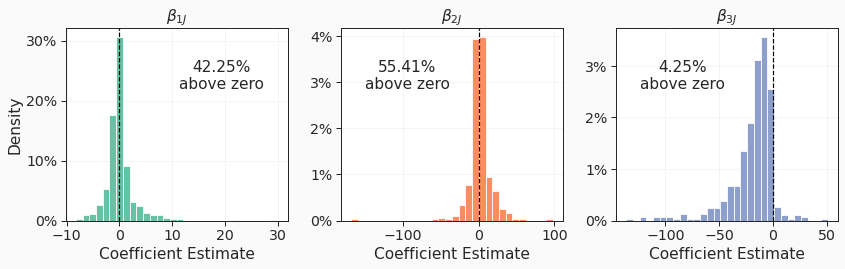

In [89]:
jump_cols = [x for x in reg_results_df.columns if 'jump' in x]
jump_coeff_est_df = reg_results_df.query('type == "params"')[jump_cols].copy()

fig, axs = plt.subplots(figsize = (12,4), ncols = 3)
pal = sns.color_palette('Set2', 3)

for i in range(len(jump_coeff_est_df.columns)):
    
    col = jump_coeff_est_df.columns[i]
    ax = axs.reshape(-1)[i]
    
    ax.hist(jump_coeff_est_df[col], bins = 30, color = pal[i], density = True)
    ax.axvline(0, 0, 1, color = 'k', ls = 'dashed')
    ax.set_title('$\\beta_{' + str(i+1) + 'J}$')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals = 0))
    
    if i == 0:
        ax.text(0.7, 0.75, f'{np.mean(jump_coeff_est_df[col] > 0):0.2%}\nabove zero', 
                va = 'center', ha = 'center', transform=ax.transAxes)
        ax.set_ylabel('Density')

    if i == 1:
        ax.text(0.3, 0.75, f'{np.mean(jump_coeff_est_df[col] > 0):0.2%}\nabove zero', 
                va = 'center', ha = 'center', transform=ax.transAxes)
    
    if i == 2:
        ax.text(0.3, 0.75, f'{np.mean(jump_coeff_est_df[col] > 0):0.2%}\nabove zero', 
                va = 'center', ha = 'center', transform=ax.transAxes)
        
    ax.set_xlabel('Coefficient Estimate')
    
plt.tight_layout()
plt.savefig('../exhibits/harjit_coeff_dist.pdf')

## Extract Beta_{1,t} 

In [81]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [82]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, ['AMZN', 'AAPL', 'GOOG'], chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_ar1_df = pd.concat(results)

In [71]:
merged_df = data_rv_df.merge(
    reg_results_df.query('type == "params"').rename(
        columns={x: ("coeff_" + x) for x in reg_results_df.columns if x != "ticker"}
    ),
    on="ticker",
    how="left",
)

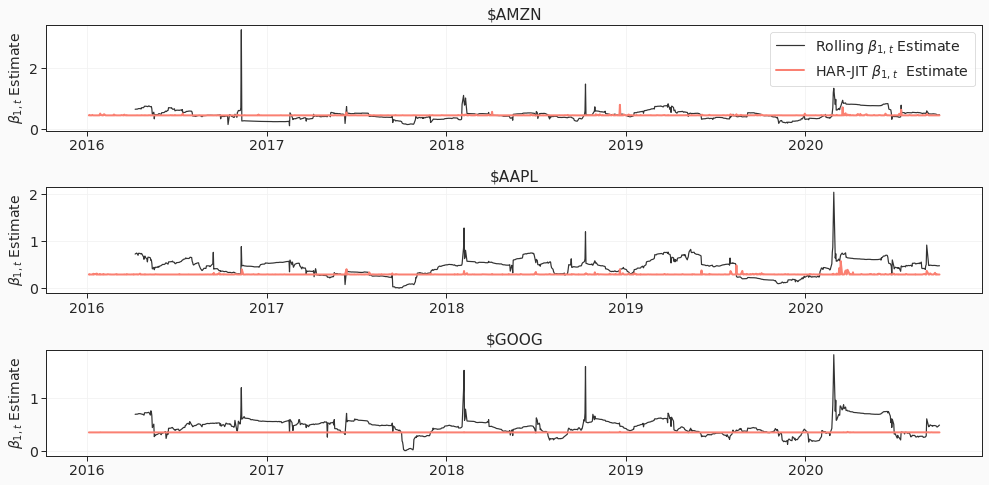

In [93]:
# Implied AR(1) coefficient estimate
fig, axs = plt.subplots(figsize=(14, 7), nrows = 3)
ticker_list = ["AMZN", 'AAPL', 'GOOG']

merged_df["beta_1_est"] = (
    merged_df["coeff_rv_lag_1"]
    + merged_df["sum_jump_p2_1_lag_1"] * merged_df["coeff_rv_lag_1:sum_jump_p2_1_lag_1"]
)

ax = axs[0]
for i in range(len(ticker_list)):
    ax = axs.reshape(-1)[i]
    ticker = ticker_list[i]
    sns.lineplot(
        x="date",
        y="rv_lag_1",
        label="Rolling $\\beta_{1,t}$ Estimate",
        color="k",
        alpha=0.8,
        data=rolling_ar1_df.query("ticker == @ticker"),
        ax = ax
    )
    sns.lineplot(
        x="date",
        y="beta_1_est",
        color = 'salmon',
        lw=2,
        label="HAR-JIT $\\beta_{1,t}$  Estimate",
        data=merged_df.query("ticker == @ticker"),
        ax = ax
    )
    ax.set_xlabel('')
    ax.set_ylabel("$\\beta_{1,t}$ Estimate", fontsize = 14)
    ax.set_title('$' + ticker)
    if i > 0:
        ax.get_legend().remove()
    
plt.tight_layout()
plt.savefig('../exhibits/harjit_beta1t_path.pdf')

## Plots

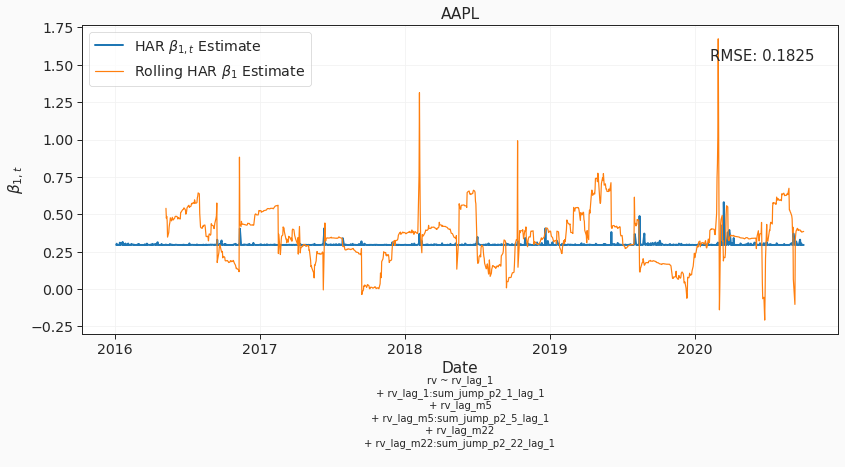

In [33]:
ticker = 'AAPL'
fig, ax = plt.subplots(figsize = (12,7))

sns.lineplot(
    x = 'date',
    y = 'beta_1_est',
    label = 'HAR $\\beta_{1,t}$ Estimate',
    lw = 2, 
    data = beta_est_df.query('ticker == @ticker')
)

sns.lineplot(
    x = 'date',
    y = 'rv_lag_1',
    label = 'Rolling HAR $\\beta_{1}$ Estimate',
    data = rolling_beta_df.query('ticker == @ticker')
)
plt.ylabel('$\\beta_{1,t}$')
plt.xlabel('Date')
plt.title(ticker)
ax.text(0.5, -0.25, reg_formula, ha = 'center', va = 'center', fontsize = 10, transform = ax.transAxes)

# RMSE
merged_df = rolling_beta_df[['ticker', 'date', 'rv_lag_1']].merge(beta_est_df[['ticker', 'date', 'beta_1_est']], on = ['ticker', 'date'])
ticker_merged_df = merged_df.query('ticker == @ticker').copy()
rmse_est = np.sqrt(np.mean(np.square(ticker_merged_df['rv_lag_1'] - ticker_merged_df['beta_1_est'])))
ax.text(0.9, 0.9, f'RMSE: {np.round(rmse_est, 4)}', ha = 'center', va = 'center', fontsize = 15, transform = ax.transAxes)

plt.tight_layout()
timestamp = ''.join(c for c in str(pd.to_datetime(dt.datetime.now())) if c.isdigit())
# plt.savefig(f'../exhibits/temp/har_beta_estimates_{timestamp}.pdf')

# Persistence Estimation

## Estimate HAR

In [ ]:
# rv ~ rv_lag_1 + rv_lag_1:sum_jump_p2_pos_1_lag_1 + rv_lag_1:sum_jump_p2_neg_1_lag_1
# + rv_lag_1:sum_jump_p2_pos_5_lag_1 + rv_lag_1:sum_jump_p2_neg_5_lag_1
# + rv_lag_1:sum_jump_p2_pos_22_lag_1 + rv_lag_1:sum_jump_p2_neg_22_lag_1
# + rv_lag_m5 + rv_lag_m22

In [ ]:
data_rv_df['rv_har_sum'] = data_rv_df['rv_lag_1'] + data_rv_df['rv_lag_m5'] + data_rv_df['rv_lag_m22']

In [ ]:
reg_formula = """
rv ~ rv_lag_1
+ rv_lag_1:sum_jump_p2_pos_1_lag_1
+ rv_lag_1:sum_jump_p2_5_lag_1
+ rv_lag_1:sum_jump_p2_22_lag_1
+ rv_lag_m5
+ rv_lag_m5:sum_jump_p2_1_lag_1
+ rv_lag_m5:sum_jump_p2_5_lag_1
+ rv_lag_m5:sum_jump_p2_22_lag_1
+ rv_lag_m22
+ rv_lag_m22:sum_jump_p2_1_lag_1
+ rv_lag_m22:sum_jump_p2_5_lag_1
+ rv_lag_m22:sum_jump_p2_22_lag_1
"""

In [ ]:
%%time
def reg_ticker(ticker, diag = False):

    fit = smf.ols(reg_formula, data_rv_df.query("ticker == @ticker")).fit(
        cov_type="HAC", cov_kwds={"maxlags": 22}
    )

    fit_results_df = pd.DataFrame(
        [fit.params, np.maximum(fit.pvalues, 1e-6)], index=["params", "pvalues"]
    ).reset_index()
    fit_results_df.rename(columns = {'index': 'type'}, inplace = True)
    fit_results_df["ticker"] = ticker
    
    if diag:
        return fit

    return fit_results_df

# Run HARs
tickers = ['NFLX', 'AAPL', 'AMZN']# data_rv_df['ticker'].unique()
results = []

# with Pool(8) as p:
#     for fit_results_df in tqdm(p.imap_unordered(reg_ticker, tickers, chunksize = 5), total=len(tickers)):
#         results.append(fit_results_df)


for fit_results_df in tqdm(map(reg_ticker, tickers), total=len(tickers)):
    results.append(fit_results_df)

reg_results_df = pd.concat(results)

In [ ]:
reg_ticker("AAPL", diag = True).summary()

## Extract Persistence

In [ ]:
# All interaction terms
beta_interact_terms = [
    x for x in reg_results_df.columns if ':' in x
]

beta_interact_terms_split = [x.split(':')[-1] for x in beta_interact_terms]

In [ ]:
reg_results_fmt_df = reg_results_df.query('type == "params"')[beta_interact_terms + ['ticker']]
reg_results_fmt_df.columns = [x + ':coeff' for x in beta_interact_terms] + ['ticker']
reg_results_fmt_df.sort_values(by = 'ticker')

In [ ]:
# Beta SUM Intercept (sum of beta's on standard HAR terms)
reg_results_int_df = reg_results_df.query('type == "params"')[['ticker', 'rv_lag_1', 'rv_lag_m5', 'rv_lag_m22']].reset_index(drop = True)
reg_results_int_df['intercept_sum'] = reg_results_int_df[['rv_lag_1', 'rv_lag_m5', 'rv_lag_m22']].sum(axis=1)
reg_results_int_df

In [ ]:
# Construct dataframe wtih beta_1 estimates
beta_est_df = data_rv_df.copy()
beta_est_df = beta_est_df.merge(reg_results_fmt_df, on = 'ticker', how = 'left')
beta_est_df = beta_est_df.merge(reg_results_int_df, on = 'ticker', how = 'left')
beta_est_df['beta_1_est'] = beta_est_df['intercept_sum']

for col in beta_interact_terms:
    beta_est_df["beta_1_est"] = (
        beta_est_df["beta_1_est"]
        + beta_est_df[col + ":coeff"] * beta_est_df[col.split(":")[-1]]
    )

In [ ]:
## Double check

# Params
display(reg_results_df.query('ticker == "AMZN" & type == "params"'))

# Sample of output
display(
    beta_est_df.query('ticker == "AMZN"').sample(3)[
        beta_interact_terms_split[:] + ["intercept_sum", "beta_1_est"]
    ]
)

## Plots

In [ ]:
ticker = 'AAPL'
fig, ax = plt.subplots(figsize = (12,7))

sns.lineplot(
    x = 'date',
    y = 'beta_1_est',
    label = 'HAR Persistence Estimate',
    lw = 2, 
    data = beta_est_df.query('ticker == @ticker')
)

sns.lineplot(
    x = 'date',
    y = 'persistence',
    label = 'Rolling HAR Persistence Estimate',
    data = rolling_beta_df.query('ticker == @ticker')
)
plt.ylabel('$\\beta_{1,t}$')
plt.xlabel('Date')
plt.title(ticker)
ax.text(0.5, -0.25, reg_formula, ha = 'center', va = 'center', fontsize = 10, transform = ax.transAxes)

# plt.title(f'$\\beta_{"{1,t}"} = f$({  ",".join(beta_1_terms_split[1:]) })')

plt.tight_layout()
timestamp = ''.join(c for c in str(pd.to_datetime(dt.datetime.now())) if c.isdigit())
plt.savefig(f'../exhibits/temp/har_betasum_estimates_{timestamp}.pdf')

## Significance

In [ ]:
sns.histplot(reg_results_df.query('type == "pvalues"')['rv_lag_1:sum_jump_p2_neg_1_lag_1'])

In [ ]:
plt.figure(figsize = (10,5))
sns.scatterplot(
    x="params",
    y="pvalues",
    label = 'Squared Negative Jumps',
    color = 'slateblue',
    data=reg_results_df
    .pivot(index="ticker", columns="type", values="rv_lag_1:sum_jump_p2_neg_1_lag_1")
    .reset_index(),
)
sns.scatterplot(
    x="params",
    y="pvalues",
    label = 'Squared Positive Jumps',
    color = 'tomato',
    data=reg_results_df
    .pivot(index="ticker", columns="type", values="rv_lag_1:sum_jump_p2_pos_1_lag_1")
    .reset_index(),
)

plt.axhline(0.05,-1,1, color = 'seagreen', lw = 2, ls = 'solid', label = 'p = 0.05')
plt.axhline(0.01,-1,1, color = 'green', lw = 2, ls = 'dashed', label = 'p = 0.01')
plt.axhline(0.001,-1,1, color = 'darkgreen', lw = 2, ls = 'dotted', label = 'p = 0.001')
plt.axvline(0,0,1,color = 'k', ls = 'solid')
plt.legend()
plt.yscale('log')

# Long Memory / Short Memory

In [112]:
data_rv_df['quarter'] = data_rv_df['date'].dt.quarter

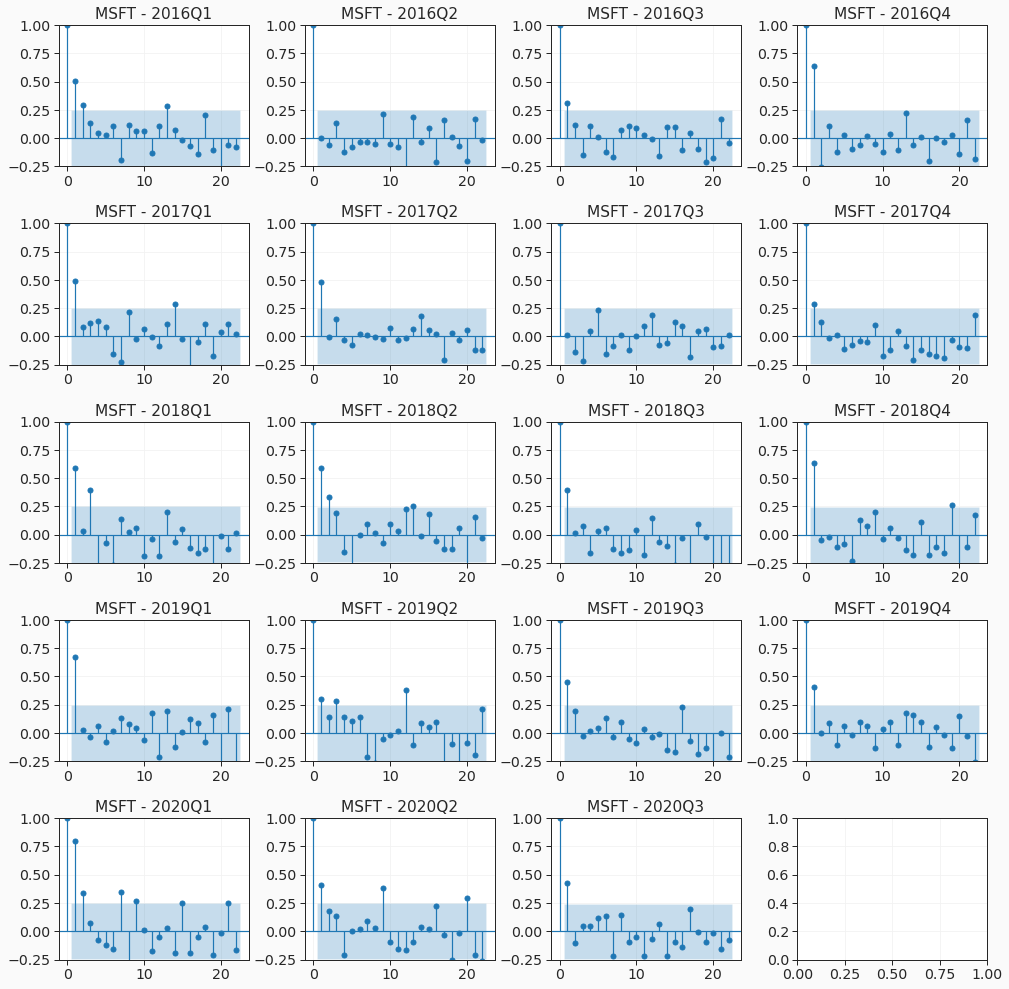

In [130]:
ticker = 'MSFT'

    
fig, axs = plt.subplots(figsize = (14,14), ncols = 4, nrows = 5)

#plt.figure(figsize = (12,5))
for i in range(5):
    year = i + 2016
    for j in range(4):
        quarter = j + 1
        
        if year == 2020 and quarter == 4: 
            continue
        
        Y = data_rv_df.query('ticker == @ticker & year == @year & quarter == @quarter')['rv']
    #     pd.plotting.autocorrelation_plot(Y)
        ax = axs[i,j]
        tsaplots.plot_pacf(Y, lags = 22, ax = ax)
#         plt.xlim(0,50)
        ax.set_ylim(-0.25, 1)
        ax.set_title(f'{ticker} - {year}Q{quarter}')
        
plt.tight_layout()

In [116]:
[i,j]

[2, 0]